In [1]:
!pip install -q ultralytics 
!pip install -q kaggle
!pip install -q seaborn

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patches, patheffects

import os
import json
import zipfile

import torch
from torch.utils.data import Dataset
import cv2

from scipy.optimize import linear_sum_assignment
from typing import List, Tuple, Dict

%matplotlib inline

In [53]:
import sys
sys.path.append('../object_detection')  # adjust path as needed
from format_data import format_gt, format_model_predictions
from pred_gt_matching import match_predictions_to_gt_greedy
from classify_pred import process_single_class_single_image
from vis import visualize_detection_results, create_detection_summary_plot, plot_yolo_results

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two sets of bounding boxes.
    Assumes box1 and box2 are in format [x_min, y_min, x_max, y_max].

    Args:
        box1 (np.array): A NumPy array of bounding boxes of shape (n, 4).
        box2 (np.array): A NumPy array of bounding boxes of shape (m, 4).

    Returns:
        np.array: A NumPy array of shape (n, m) containing the IoU scores for each pair of boxes.
    """
    # Ensure inputs are NumPy arrays
    box1 = np.array(box1)
    box2 = np.array(box2)

    # Handle empty input arrays
    if box1.shape[0] == 0 or box2.shape[0] == 0:
        return np.zeros((box1.shape[0], box2.shape[0]))

    # Reshape box1 for broadcasting: (n, 1, 4)
    box1 = box1[:, np.newaxis, :]
    # Reshape box2 for broadcasting: (1, m, 4)
    box2 = box2[np.newaxis, :, :]

    # Determine the coordinates of the intersection rectangles
    x_min_inter = np.maximum(box1[:, :, 0], box2[:, :, 0])
    y_min_inter = np.maximum(box1[:, :, 1], box2[:, :, 1])
    x_max_inter = np.minimum(box1[:, :, 2], box2[:, :, 2])
    y_max_inter = np.minimum(box1[:, :, 3], box2[:, :, 3])

    # Calculate the area of the intersection rectangles
    inter_width = np.maximum(0, x_max_inter - x_min_inter)
    inter_height = np.maximum(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # Calculate the area of both sets of bounding boxes
    box1_area = (box1[:, :, 2] - box1[:, :, 0]) * (box1[:, :, 3] - box1[:, :, 1])
    box2_area = (box2[:, :, 2] - box2[:, :, 0]) * (box2[:, :, 3] - box2[:, :, 1])

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area

    # Handle the case of zero union area to avoid division by zero
    # Use np.where to return 0.0 where union_area is 0, and the calculated IoU otherwise.
    iou = np.where(union_area == 0, 0.0, inter_area / union_area)

    return iou

# # Example usage with arrays:
# boxes_a = np.array([[10, 10, 50, 50], [20, 20, 60, 60]])
# boxes_b = np.array([[15, 15, 55, 55], [30, 30, 70, 70]])
# iou_matrix = calculate_iou(boxes_a, boxes_b)
# print(f"IoU Matrix:\n{iou_matrix}")

In [6]:
# # Set up Kaggle credentials from Colab secrets
# from google.colab import userdata
# kaggle_username = userdata.get('KAGGLE_USERNAME')
# kaggle_key = userdata.get('KAGGLE_KEY')

# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [7]:
if IN_COLAB:
    # Set up Kaggle credentials from Colab secrets
    from google.colab import userdata
    kaggle_username = userdata.get('KAGGLE_USERNAME')
    kaggle_key = userdata.get('KAGGLE_KEY')

    # Step 2: Create kaggle.json file with credentials
    kaggle_config = {
        "username": kaggle_username,
        "key": kaggle_key
    }
    
    # Create .kaggle directory and save credentials
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json', 'w') as f:
        json.dump(kaggle_config, f)

    DATA_PATH = "/content/open-images-bus-trucks"
else:
    # Load Kaggle credentials from local file
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'r') as f:
        creds = json.load(f)
    kaggle_username = creds['username']
    kaggle_key = creds['key']

    DATA_PATH = "./data/open-images-bus-trucks"

# Set environment variables (optional, for some APIs that expect them)
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [8]:


# Step 3: Download the Open Images Bus Trucks dataset
# Replace with the actual dataset path from Kaggle
dataset_name = "sixhky/open-images-bus-trucks"  # Adjust this to the correct dataset name

print(f"Downloading dataset: {dataset_name}")
!kaggle datasets download -d {dataset_name}

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
 62%|████████████████████████▊               | 227M/367M [00:00<00:00, 2.37GB/s]
100%|████████████████████████████████████████| 367M/367M [00:00<00:00, 2.38GB/s]


In [12]:
# Step 4: Extract the downloaded zip file
zip_filename = f"{dataset_name.split('/')[-1]}.zip"

print(f"Extracting {zip_filename} to {DATA_PATH}")
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

# Step 5: List the contents of the extracted folder
print("\nDataset contents:")
for root, dirs, files in os.walk(DATA_PATH):
    level = root.replace(DATA_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:10]:  # Show first 10 files
        print(f"{subindent}{file}")
    if len(files) > 10:
        print(f"{subindent}... and {len(files) - 10} more files")

# Step 6: Clean up the zip file
os.remove(zip_filename)
print(f"\nCleaned up {zip_filename}")

print(f"\nDataset successfully downloaded and extracted to: {DATA_PATH}")

Extracting open-images-bus-trucks.zip to ./data/open-images-bus-trucks

Dataset contents:
open-images-bus-trucks/
  df.csv
  images/
    images/
      78bd6d45af1a2d6b.jpg
      d3b128296d6dc535.jpg
      1db4cdb2a64c92f8.jpg
      60251f63997c8035.jpg
      e9b9b22b48d77cba.jpg
      fbaaa97adfa57f28.jpg
      7e282f13b4896297.jpg
      bde6050232a4b331.jpg
      51a04c455db65f51.jpg
      31f2a0d0b0693c54.jpg
      ... and 15215 more files

Cleaned up open-images-bus-trucks.zip

Dataset successfully downloaded and extracted to: ./data/open-images-bus-trucks


In [13]:
# Reading the csv
IMAGE_ROOT = DATA_PATH + '/images'
DF_RAW = pd.read_csv(DATA_PATH + '/df.csv')
display(DF_RAW.head())
print(DF_RAW.shape)
class_names = DF_RAW['LabelName'].unique()
print(class_names)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


(24062, 21)
['Bus' 'Truck']




Note that XMin, XMax, YMin, and YMax correspond to the ground truth of the bounding box of the image.


In [14]:
# create a custom dataset
class OpenImages(Dataset):
    def __init__(self, df, image_folder = IMAGE_ROOT):
        self.df = df
        self.unique_images = df['ImageID'].unique()
        self.root = image_folder

    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_path = f'{self.root}/images/{image_id}.jpg'
        image = cv2.imread(image_path, 1)  # converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        df = self.df.copy()
        df = df[df['ImageID'] == image_id]  # getting the row based on the index
        h, w, _ = image.shape
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16)
        classes = df['LabelName'].values.tolist()

        return image, boxes, classes, image_path

In [15]:
# drawing functions - fastai style
def bb_hw(a):
    """ convert x_min, y_min, x_max, y_max to width, height """
    # return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])
    return np.array([a[0], a[1], a[2]-a[0], a[3]-a[1]])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, bb, color='white'):
    patch = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 2)

def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_im(im, bbs, classes, ax=None, figsize=None, title=None, color='white'):
    """ ann = ([bb], [class]) """
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax = show_img(im, figsize=figsize, ax=ax)
    # for bb, cla in ann:
    for i, bb in enumerate(bbs):
        bb = bb_hw(bb)
        draw_rect(ax, bb, color=color)
        draw_text(ax, bb[:2], classes[i], color=color)
    if title:
        ax.set_title(title)
    return ax

In [16]:
ds = OpenImages(DF_RAW)
len(ds)

15225

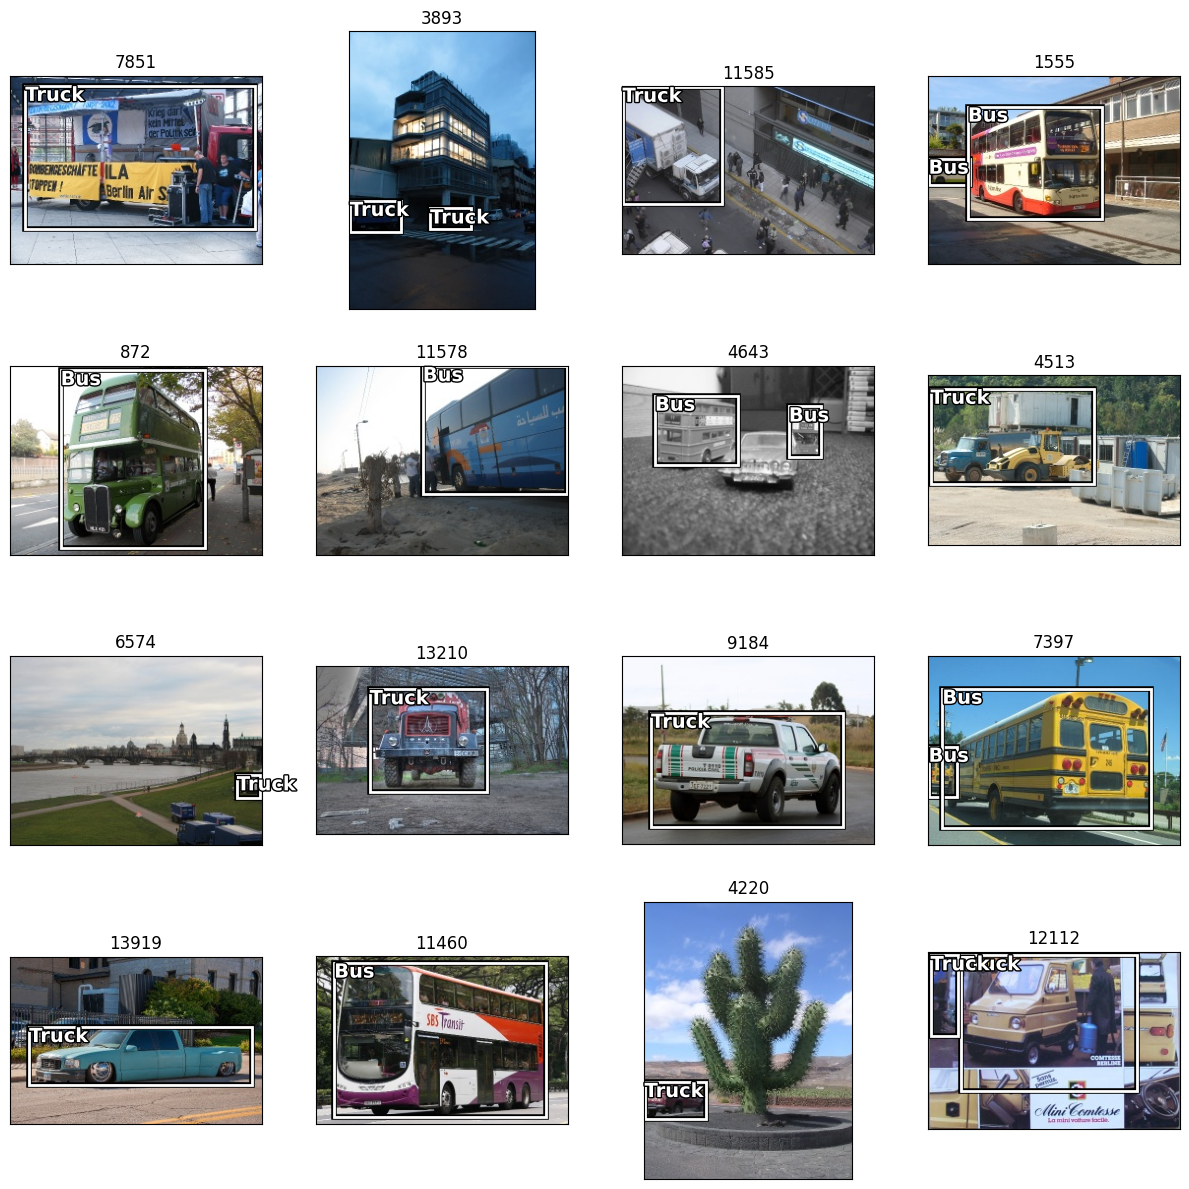

In [17]:
# Randomly select 16 indices
random_indices = np.random.choice(len(ds), 16, replace=False)

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through the random indices and display the images
for i, idx in enumerate(random_indices):
    im, bbs, clss, _ = ds[idx]
    draw_im(im, bbs=bbs, classes=clss, ax=axes[i], figsize=(3,3), title=idx)

plt.tight_layout()
plt.show()

Found 146 images containing both buses and trucks.


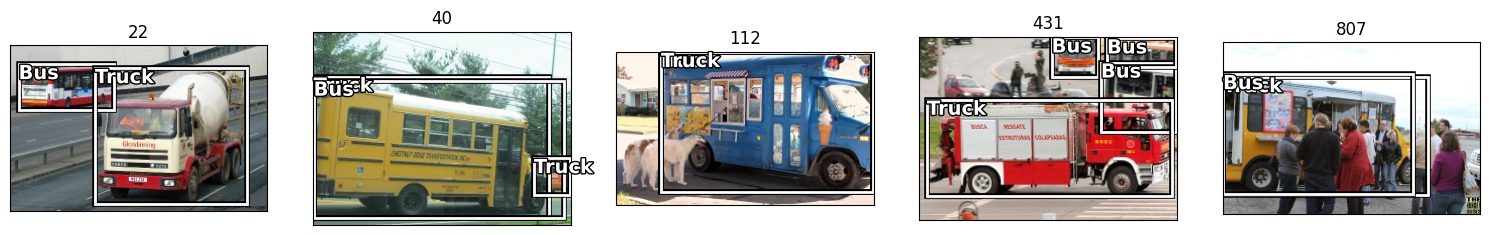

In [18]:
# Find ImageIDs that have both 'Bus' and 'Truck' labels
bus_truck_image_ids = DF_RAW.groupby('ImageID')['LabelName'].apply(lambda x: set(x) == {'Bus', 'Truck'})
bus_truck_image_ids = bus_truck_image_ids[bus_truck_image_ids].index.tolist()

print(f"Found {len(bus_truck_image_ids)} images containing both buses and trucks.")

# Display the first few images (e.g., 5 images)
num_images_to_show = min(5, len(bus_truck_image_ids))

if num_images_to_show > 0:
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
    if num_images_to_show == 1:
        axes = [axes] # Make it iterable if there's only one subplot

    for i in range(num_images_to_show):
        image_id = bus_truck_image_ids[i]
        # Find the index of this image_id in the unique_images list of the dataset
        idx = np.where(ds.unique_images == image_id)[0][0]
        im, bbs, clss, _ = ds[idx]
        draw_im(im, bbs=bbs, classes=clss, ax=axes[i], title=idx)

    plt.tight_layout()
    plt.show()
else:
    print("No images found with both buses and trucks.")

Now, let's load the model and the corresponding image processing class.

Next, we'll select an image from your dataset and run the model on it. We'll then visualize the results with the detected bounding boxes and labels.

# predictions per image

In [ ]:

def classify_predictions_per_image(predictions: List[Dict],
                                 ground_truths: List[Dict],
                                 iou_matrix: np.ndarray,
                                 iou_threshold: float = 0.5,
                                 use_hungarian: bool = False) -> Dict:
    """
    Classify predictions as TP or FP for a single image and single class.

    Args:
        predictions: List of prediction dicts with keys: ['bbox', 'score', 'class']
        ground_truths: List of ground truth dicts with keys: ['bbox', 'class']
        iou_matrix: Shape (num_predictions, num_gt)
        iou_threshold: IoU threshold for positive matches
        use_hungarian: Whether to use Hungarian algorithm (optimal) or greedy matching

    Returns:
        Dictionary with classification results
    """
    if use_hungarian:
        matched_pred_idx, matched_gt_idx, unmatched_pred_idx = match_predictions_to_gt_hungarian(
            iou_matrix, iou_threshold
        )
    else:
        matched_pred_idx, matched_gt_idx, unmatched_pred_idx = match_predictions_to_gt_greedy(
            iou_matrix, iou_threshold
        )

    # Classify predictions
    tp_predictions = []
    fp_predictions = []

    # True positives - matched predictions
    for pred_idx in matched_pred_idx:
        pred_info = predictions[pred_idx].copy()
        pred_info['classification'] = 'TP'
        tp_predictions.append(pred_info)

    # False positives - unmatched predictions
    for pred_idx in unmatched_pred_idx:
        pred_info = predictions[pred_idx].copy()
        pred_info['classification'] = 'FP'
        fp_predictions.append(pred_info)

    # False negatives - unmatched ground truths
    all_gt_indices = set(range(len(ground_truths)))
    matched_gt_set = set(matched_gt_idx)
    unmatched_gt_indices = list(all_gt_indices - matched_gt_set)

    fn_ground_truths = []
    for gt_idx in unmatched_gt_indices:
        gt_info = ground_truths[gt_idx].copy()
        gt_info['classification'] = 'FN'
        fn_ground_truths.append(gt_info)

    return {
        'tp_predictions': tp_predictions,
        'fp_predictions': fp_predictions,
        'fn_ground_truths': fn_ground_truths,
        'num_tp': len(tp_predictions),
        'num_fp': len(fp_predictions),
        'num_fn': len(fn_ground_truths)
    }

def process_single_class_single_image(predictions: List[Dict],
                                    ground_truths: List[Dict],
                                    target_class: int,
                                    iou_matrix: np.ndarray,
                                    iou_threshold: float = 0.5,
                                    use_hungarian: bool = False) -> Dict:
    """
    Complete processing pipeline for one class in one image.

    Args:
        predictions: All predictions for the image
        ground_truths: All ground truths for the image
        target_class: Class ID to process
        iou_matrix: IoU matrix for this class only
        iou_threshold: IoU threshold for matching
        use_hungarian: Matching algorithm choice

    Returns:
        Classification results for this class in this image
    """
    # Filter predictions and ground truths for target class
    class_predictions = [p for p in predictions if p['class'] == target_class]
    class_ground_truths = [gt for gt in ground_truths if gt['class'] == target_class]

    if len(class_predictions) == 0 and len(class_ground_truths) == 0:
        return {
            'tp_predictions': [],
            'fp_predictions': [],
            'fn_ground_truths': [],
            'num_tp': 0,
            'num_fp': 0,
            'num_fn': 0
        }
    elif len(class_predictions) == 0:
        # No predictions, all ground truths are FN
        fn_ground_truths = [dict(gt, classification='FN') for gt in class_ground_truths]
        return {
            'tp_predictions': [],
            'fp_predictions': [],
            'fn_ground_truths': fn_ground_truths,
            'num_tp': 0,
            'num_fp': 0,
            'num_fn': len(fn_ground_truths)
        }
    elif len(class_ground_truths) == 0:
        # No ground truths, all predictions are FP
        fp_predictions = [dict(p, classification='FP') for p in class_predictions]
        return {
            'tp_predictions': [],
            'fp_predictions': fp_predictions,
            'fn_ground_truths': [],
            'num_tp': 0,
            'num_fp': len(fp_predictions),
            'num_fn': 0
        }

    # Normal case - both predictions and ground truths exist
    return classify_predictions_per_image(
        class_predictions, class_ground_truths, iou_matrix,
        iou_threshold, use_hungarian
    )

# Example usage
def example_usage():
    """
    Example of how to use the matching functions.
    """
    # Example predictions (should be sorted by confidence score descending)
    predictions = [
        {'bbox': [10, 10, 50, 50], 'score': 0.9, 'class': 1},
        {'bbox': [60, 60, 100, 100], 'score': 0.8, 'class': 1},
        {'bbox': [15, 15, 45, 45], 'score': 0.7, 'class': 1},  # Overlaps with first
    ]

    # Example ground truths
    ground_truths = [
        {'bbox': [12, 12, 48, 48], 'class': 1},  # Should match first prediction
        {'bbox': [200, 200, 240, 240], 'class': 1},  # No matching prediction
    ]

    # Example IoU matrix (you would calculate this with your IoU function)
    # Shape: (num_predictions, num_ground_truths)
    iou_matrix = np.array([
        [0.85, 0.0],   # First prediction: high IoU with first GT, no overlap with second
        [0.1, 0.0],    # Second prediction: low IoU with both GTs
        [0.75, 0.0],   # Third prediction: medium-high IoU with first GT
    ])

    # Process this class for this image
    results = process_single_class_single_image(
        predictions, ground_truths, target_class=1,
        iou_matrix=iou_matrix, iou_threshold=0.5,
        use_hungarian=True
    )

    print(f"TP: {results['num_tp']}")
    print(f"FP: {results['num_fp']}")
    print(f"FN: {results['num_fn']}")

    return results

if __name__ == "__main__":
    example_usage()

# visualization functions

In [ ]:
# from typing import Union, Dict, Optional, Tuple, List
# import os
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from typing import Dict, List, Tuple, Optional, Union
from PIL import Image



def visualize_detection_results(image: Union[str, np.ndarray, Image.Image],
                                results: Dict,
                                ground_truths: Optional[List[Dict]] = None,
                                class_name: str = "Object",
                                iou_threshold: float = 0.5,
                                show_confidence: bool = True,
                                bbox_format: str = 'xyxy',
                                figsize: Tuple[int, int] = (10, 7),
                                save_path: Optional[str] = None) -> plt.Figure:
    """
    Visualize object detection results and ground truths on an image.

    Args:
        image: Image path, numpy array, or PIL Image
        results: Output from process_single_class_single_image()
        ground_truths: List of all GT boxes, each a dict with at least 'bbox'
        class_name: Display class name
        iou_threshold: Threshold used for matching
        show_confidence: Whether to show confidence score
        show_iou: Not used here
        bbox_format: 'xyxy' or 'xywh'
        figsize: Figure size
        save_path: Optional output path

    Returns:
        matplotlib Figure
    """
    if isinstance(image, str):
        if not os.path.exists(image):
            raise FileNotFoundError(f"Image not found: {image}")
        img = Image.open(image)
        img_array = np.array(img)
    elif isinstance(image, Image.Image):
        img_array = np.array(image)
    elif isinstance(image, np.ndarray):
        img_array = image
    else:
        raise ValueError("Unsupported image type")

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img_array)
    ax.set_title(f'{class_name} Detection (IoU ≥ {iou_threshold}) | '
                 f'TP: {results["num_tp"]}, FP: {results["num_fp"]}, FN: {results["num_fn"]}',
                 fontsize=14, fontweight='bold')

    colors = {
        'TP': '#00FF00',   # green
        'FP': '#FF0000',   # red
        'FN': '#0000FF',   # blue
        'GT': '#FFA500'    # orange
    }

    def to_xyxy(bbox):
        if bbox_format == 'xyxy':
            return bbox
        elif bbox_format == 'xywh':
            x, y, w, h = bbox
            return [x, y, x + w, y + h]
        else:
            raise ValueError("Invalid bbox_format")

    # Draw ground truths
    if ground_truths:
        for gt in ground_truths:
            x1, y1, x2, y2 = to_xyxy(gt['bbox'])
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=1.5, edgecolor=colors['GT'],
                             facecolor='none', linestyle='-')
            ax.add_patch(rect)
            ax.text(x1, y2 + 5, "GT",
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['GT'], alpha=0.5),
                    fontsize=9, fontweight='bold', color='black')

    # TP
    for pred in results['tp_predictions']:
        x1, y1, x2, y2 = to_xyxy(pred['bbox'])
        label = "TP"
        if show_confidence and 'score' in pred:
            label += f" ({pred['score']:.2f})"
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=3, edgecolor=colors['TP'], facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['TP'], alpha=0.7),
                fontsize=10, fontweight='bold')

    # FP
    for pred in results['fp_predictions']:
        x1, y1, x2, y2 = to_xyxy(pred['bbox'])
        label = "FP"
        if show_confidence and 'score' in pred:
            label += f" ({pred['score']:.2f})"
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=3, edgecolor=colors['FP'], facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['FP'], alpha=0.7),
                fontsize=10, fontweight='bold', color='white')

    # FN
    for gt in results['fn_ground_truths']:
        x1, y1, x2, y2 = to_xyxy(gt['bbox'])
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=3, edgecolor=colors['FN'], facecolor='none', linestyle=':')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, "FN",
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['FN'], alpha=0.7),
                fontsize=10, fontweight='bold', color='white')

    # Legend
    ax.legend(handles=[
        Patch(color=colors['TP'], label='True Positive'),
        Patch(color=colors['FP'], label='False Positive'),
        Patch(color=colors['FN'], label='False Negative'),
        Patch(color=colors['GT'], label='Ground Truth')
    ], loc='upper right', fontsize=10)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")

    return fig


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image
import cv2
from typing import Dict, List, Tuple, Optional, Union
import os

def visualize_matching_comparison(image: Union[str, np.ndarray, Image.Image],
                                results_hungarian: Dict,
                                results_greedy: Dict,
                                class_name: str = "Object",
                                iou_threshold: float = 0.5,
                                bbox_format: str = 'xyxy',
                                figsize: Tuple[int, int] = (16, 8),
                                save_path: Optional[str] = None) -> plt.Figure:
    """
    Compare Hungarian vs Greedy matching results side by side.

    Args:
        image: Image to visualize
        results_hungarian: Results from Hungarian algorithm
        results_greedy: Results from Greedy algorithm
        class_name: Class name for display
        iou_threshold: IoU threshold used
        bbox_format: Bounding box format
        figsize: Figure size
        save_path: Path to save comparison

    Returns:
        matplotlib Figure object
    """

    # Load image
    if isinstance(image, str):
        img = Image.open(image)
        img_array = np.array(img)
    elif isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Colors
    colors = {'TP': '#00FF00', 'FP': '#FF0000', 'FN': '#0000FF'}

    def plot_results(ax, results, title):
        ax.imshow(img_array)
        ax.set_title(f'{title}\nTP: {results["num_tp"]} | FP: {results["num_fp"]} | FN: {results["num_fn"]}',
                    fontsize=12, fontweight='bold')

        # Helper function
        def convert_bbox(bbox):
            if bbox_format == 'xyxy':
                return bbox
            else:  # xywh
                x, y, w, h = bbox
                return [x, y, x + w, y + h]

        # Draw all classifications
        for classification, items_key in [('TP', 'tp_predictions'), ('FP', 'fp_predictions')]:
            for item in results[items_key]:
                bbox = convert_bbox(item['bbox'])
                x1, y1, x2, y2 = bbox

                style = '-' if classification == 'TP' else '--'
                rect = Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor=colors[classification],
                               facecolor='none', linestyle=style)
                ax.add_patch(rect)

                label = f"{classification}"
                if 'score' in item:
                    label += f" ({item['score']:.2f})"

                text_color = 'black' if classification == 'TP' else 'white'
                ax.text(x1, y1-3, label,
                       bbox=dict(boxstyle="round,pad=0.2", facecolor=colors[classification], alpha=0.7),
                       fontsize=8, fontweight='bold', color=text_color)

        # Draw FN
        for item in results['fn_ground_truths']:
            bbox = convert_bbox(item['bbox'])
            x1, y1, x2, y2 = bbox

            rect = Rectangle((x1, y1), x2-x1, y2-y1,
                           linewidth=2, edgecolor=colors['FN'],
                           facecolor='none', linestyle=':')
            ax.add_patch(rect)

            ax.text(x1, y1-3, "FN",
                   bbox=dict(boxstyle="round,pad=0.2", facecolor=colors['FN'], alpha=0.7),
                   fontsize=8, fontweight='bold', color='white')

        ax.set_xticks([])
        ax.set_yticks([])

    # Plot both results
    plot_results(ax1, results_hungarian, f'{class_name} - Hungarian Matching')
    plot_results(ax2, results_greedy, f'{class_name} - Greedy Matching')

    # Add shared legend
    legend_elements = [
        patches.Patch(color=colors['TP'], label='True Positive'),
        patches.Patch(color=colors['FP'], label='False Positive'),
        patches.Patch(color=colors['FN'], label='False Negative')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02),
              ncol=3, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison saved to: {save_path}")

    return fig

def create_detection_summary_plot(results_per_class: Dict[str, Dict],
                                class_names: List[str],
                                figsize: Tuple[int, int] = (12, 6),
                                save_path: Optional[str] = None) -> plt.Figure:
    """
    Create a summary bar plot showing TP/FP/FN counts across classes.

    Args:
        results_per_class: Dict with class names as keys and results dicts as values
        class_names: List of class names for ordering
        figsize: Figure size
        save_path: Path to save the plot

    Returns:
        matplotlib Figure object
    """

    # Prepare data
    tp_counts = [results_per_class.get(cls, {'num_tp': 0})['num_tp'] for cls in class_names]
    fp_counts = [results_per_class.get(cls, {'num_fp': 0})['num_fp'] for cls in class_names]
    fn_counts = [results_per_class.get(cls, {'num_fn': 0})['num_fn'] for cls in class_names]

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(class_names))
    width = 0.25

    bars1 = ax.bar(x - width, tp_counts, width, label='True Positive', color='#00FF00', alpha=0.8)
    bars2 = ax.bar(x, fp_counts, width, label='False Positive', color='#FF0000', alpha=0.8)
    bars3 = ax.bar(x + width, fn_counts, width, label='False Negative', color='#0000FF', alpha=0.8)

    # Customize plot
    ax.set_xlabel('Classes', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title('Detection Results Summary by Class', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45 if len(max(class_names, key=len)) > 8 else 0)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)

    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Summary plot saved to: {save_path}")

    return fig



# process 1 image (demo)

In [50]:
bb = [gt['bbox'] for gt in ground_truths_all]
cls = [gt['class'] for gt in ground_truths_all]

Using cache found in /home/amir/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-7-23 Python-3.12.3 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


📦 Detected YOLO-style output format
   🔍 Found 4 raw detections
   ✅ Kept 2 predictions after confidence filtering
[{'bbox': [7.700631618499756, 20.12960433959961, 102.92423248291016, 63.97148513793945], 'score': 0.9342013001441956, 'class': 0, 'class_name': 'bus'}]


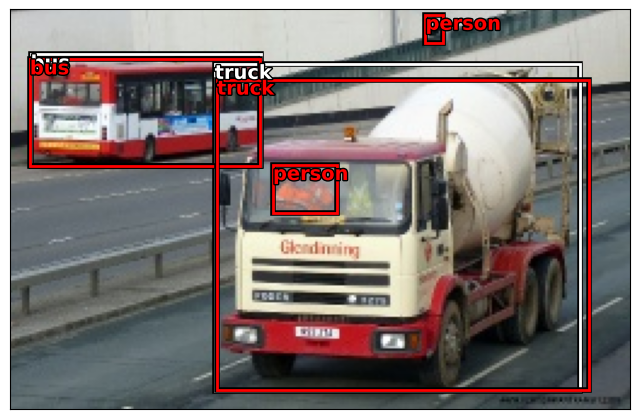

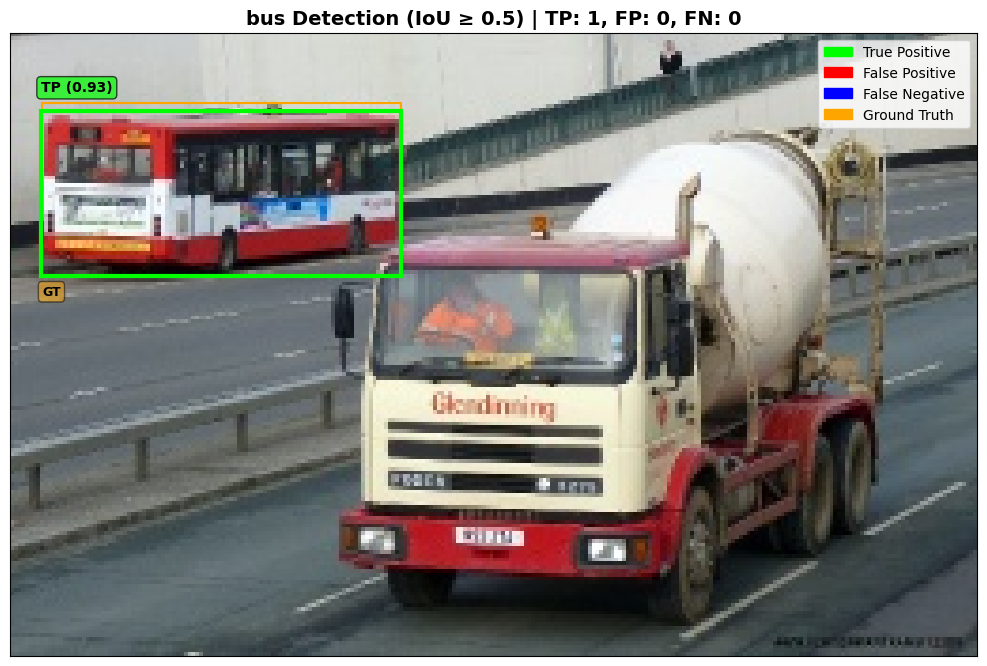

[{'bbox': [84.92683410644531, 28.48052406311035, 238.73348999023438, 156.7308349609375], 'score': 0.8832406401634216, 'class': 1, 'class_name': 'truck'}]


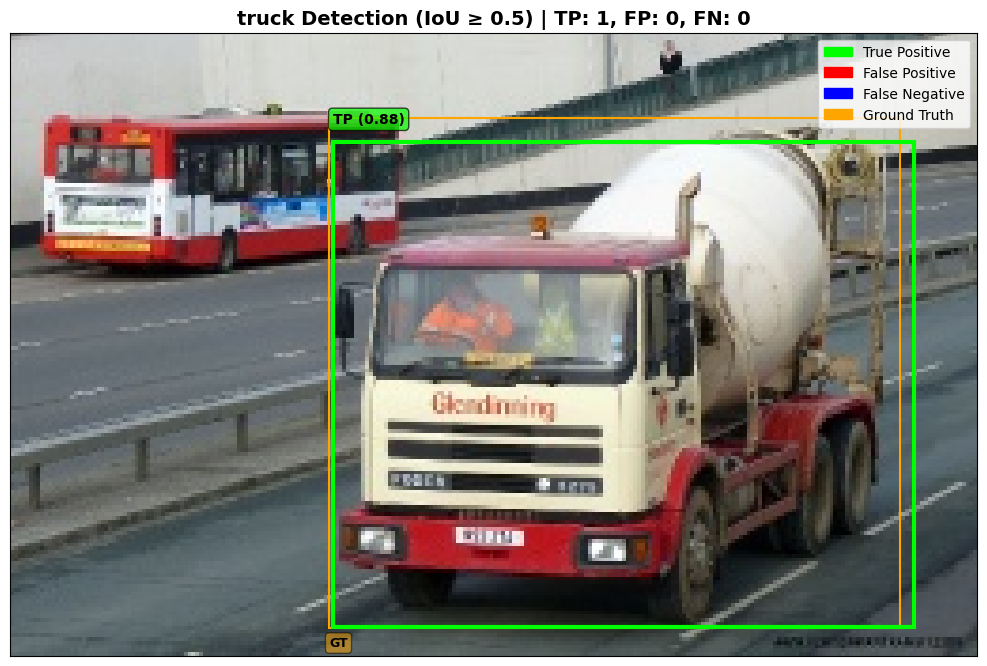


Results for class: bus
TP: 1
FP: 0
FN: 0

Results for class: truck
TP: 1
FP: 0
FN: 0


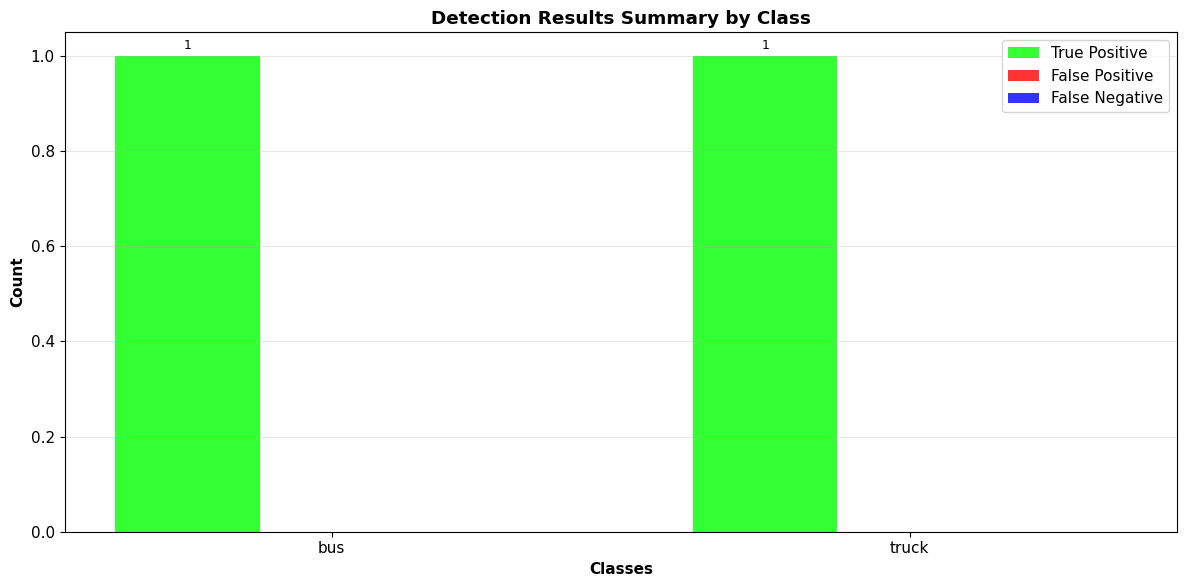

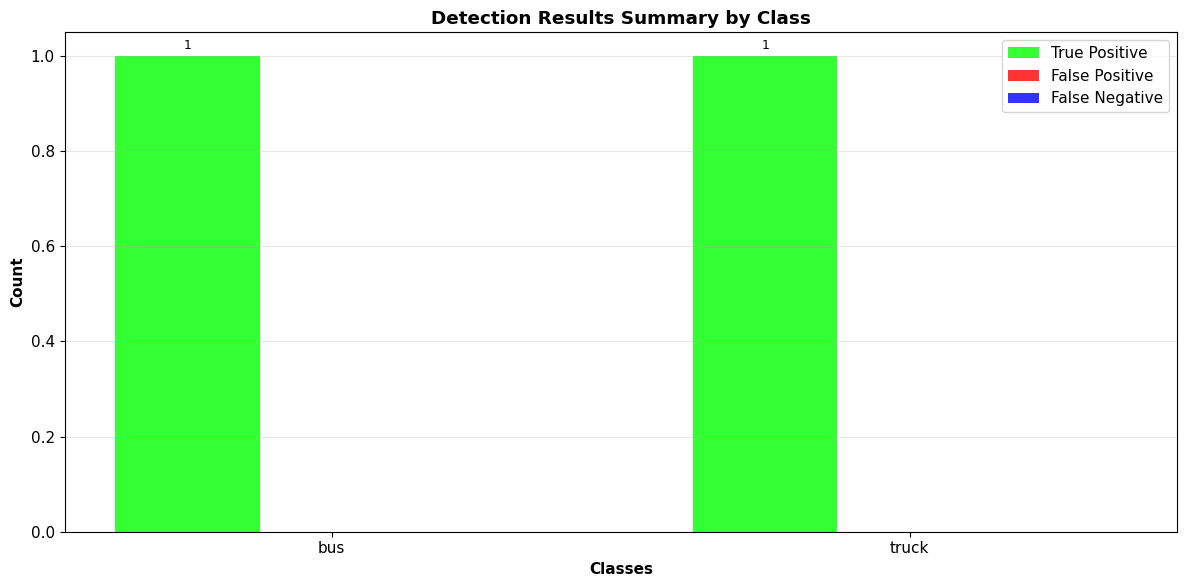

In [59]:
target_classes = ['bus', 'truck']

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)

# Select an image from your dataset (e.g., the first image)
# We'll use image 22 from the dataset for demonstration, as it contains both Bus and Truck
image, bbs, clss, image_path = ds[22]

# run model
results = model(image)

# arrange data
ground_truths_all = format_gt(bbs, clss, target_classes)
predictions_all = format_model_predictions(results, class_names)
predictions_all = predictions_all['image0.jpg']

# draw all detections and gt boxes
plot_yolo_results(results, image, model.names, ground_truths_all)

# Iterate through each target class and evaluate
eval_results = {}
for class_id, class_name in enumerate(target_classes):
    # Filter predictions for the current class
    class_predictions = [p for p in predictions_all if p['class'] == class_id]
    print(class_predictions)

    # Filter ground truths for the current class
    class_ground_truths = [gt for gt in ground_truths_all if gt['class'] == class_id]
      
    pred_boxes = np.array([p['bbox'] for p in class_predictions])
    gt_boxes = np.array([gt['bbox'] for gt in class_ground_truths])
    iou_matrix = calculate_iou(pred_boxes, gt_boxes)

    # Process this single class in this single image
    results_per_class = process_single_class_single_image(
        predictions=class_predictions, # Pass the filtered predictions
        ground_truths=class_ground_truths, # Pass the filtered ground truths
        target_class=class_id,
        iou_matrix=iou_matrix, # Pass the class-specific IoU matrix
        iou_threshold=0.5,
        use_hungarian=True # Use Hungarian matching
    )

    # Visualize the results for the current class
    # We pass the filtered ground truths for visualization
    fig = visualize_detection_results(
        image=image,
        results=results_per_class,
        ground_truths=class_ground_truths,
        class_name=class_name,
        iou_threshold=0.5,
        show_confidence=True
    )
    plt.show()

    eval_results[class_name] = results_per_class

for i, class_name in enumerate(target_classes):
    print(f"\nResults for class: {class_name}")
    print(f"TP: {eval_results[class_name]['num_tp']}")
    print(f"FP: {eval_results[class_name]['num_fp']}")
    print(f"FN: {eval_results[class_name]['num_fn']}")

create_detection_summary_plot(eval_results, target_classes)

# Evaluator class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Any, Tuple

class ObjectDetectionEvaluator:
    def __init__(self, class_names: List[str]):
        """
        Initialize the evaluator with class names.

        Args:
            class_names: List of class names (index corresponds to class_id)
        """
        self.class_names = class_names
        self.results_storage = defaultdict(list)  # {class_id: [results_per_image]}

    def calculate_iou_matrix_single_class(self, predictions: List[Dict],
                                        ground_truths: List[Dict],
                                        class_id: int) -> np.ndarray:
        """
        Calculate IoU matrix between predictions and ground truths for a specific class.

        Args:
            predictions: List of prediction dictionaries
            ground_truths: List of ground truth dictionaries
            class_id: Target class ID to filter by

        Returns:
            IoU matrix of shape (num_preds_class, num_gts_class)
        """
        # Filter predictions and ground truths by class
        class_preds = [p for p in predictions if p.get('class', p.get('class_id')) == class_id]
        class_gts = [g for g in ground_truths if g.get('class', g.get('class_id')) == class_id]

        if len(class_preds) == 0 or len(class_gts) == 0:
            return np.array([]).reshape(len(class_preds), len(class_gts))

        iou_matrix = np.zeros((len(class_preds), len(class_gts)))

        for i, pred in enumerate(class_preds):
            for j, gt in enumerate(class_gts):
                iou_matrix[i, j] = self.calculate_iou(pred['bbox'], gt['bbox'])

        return iou_matrix

    def calculate_iou(self, bbox1: List[float], bbox2: List[float]) -> float:
        """
        Calculate Intersection over Union (IoU) between two bounding boxes.

        Args:
            bbox1, bbox2: Bounding boxes in format [x1, y1, x2, y2]

        Returns:
            IoU value between 0 and 1
        """
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2

        # Calculate intersection coordinates
        x1_i = max(x1_1, x1_2)
        y1_i = max(y1_1, y1_2)
        x2_i = min(x2_1, x2_2)
        y2_i = min(y2_1, y2_2)

        # Calculate intersection area
        if x2_i <= x1_i or y2_i <= y1_i:
            intersection = 0.0
        else:
            intersection = (x2_i - x1_i) * (y2_i - y1_i)

        # Calculate union area
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0.0

    def store_results(self, image_id: str, class_id: int, results: Dict[str, Any]):
        """
        Store results for a single image and class.

        Args:
            image_id: Image identifier
            class_id: Class identifier
            results: Results dictionary from process_single_class_single_image
        """
        # Add image_id to results for tracking
        results_with_id = results.copy()
        results_with_id['image_id'] = image_id

        self.results_storage[class_id].append(results_with_id)

    def aggregate_results_for_class(self, class_id: int) -> List[Dict[str, Any]]:
        """
        Aggregate all predictions for a specific class across all images.

        Args:
            class_id: Class identifier

        Returns:
            List of all predictions with their classifications and scores
        """
        all_predictions = []

        for image_results in self.results_storage[class_id]:
            # Add TP predictions
            for pred in image_results['tp_predictions']:
                all_predictions.append({
                    'score': pred['score'],
                    'classification': 'TP',
                    'image_id': image_results['image_id'],
                    'bbox': pred['bbox']
                })

            # Add FP predictions
            for pred in image_results['fp_predictions']:
                all_predictions.append({
                    'score': pred['score'],
                    'classification': 'FP',
                    'image_id': image_results['image_id'],
                    'bbox': pred['bbox']
                })

        # Sort by confidence score in descending order
        all_predictions.sort(key=lambda x: x['score'], reverse=True)

        return all_predictions

    def calculate_total_ground_truths(self, class_id: int) -> int:
        """
        Calculate total number of ground truth objects for a class.

        Args:
            class_id: Class identifier

        Returns:
            Total number of ground truth objects
        """
        total_gts = 0
        for image_results in self.results_storage[class_id]:
            total_gts += image_results['num_tp'] + image_results['num_fn']

        return total_gts

    def calculate_precision_recall_curve(self, class_id: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Calculate precision-recall curve for a specific class.

        Args:
            class_id: Class identifier

        Returns:
            Tuple of (precision_values, recall_values, thresholds)
        """
        predictions = self.aggregate_results_for_class(class_id)
        total_gts = self.calculate_total_ground_truths(class_id)

        if len(predictions) == 0 or total_gts == 0:
            return np.array([1.0, 0.0]), np.array([0.0, 0.0]), np.array([])

        # Initialize arrays
        precisions = []
        recalls = []
        thresholds = []

        tp_count = 0
        fp_count = 0

        # Calculate precision and recall at each threshold
        for i, pred in enumerate(predictions):
            if pred['classification'] == 'TP':
                tp_count += 1
            else:  # FP
                fp_count += 1

            precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
            recall = tp_count / total_gts if total_gts > 0 else 0

            precisions.append(precision)
            recalls.append(recall)
            thresholds.append(pred['score'])

        # Add point (0, 1) at the beginning for complete curve
        precisions = [1.0] + precisions
        recalls = [0.0] + recalls

        return np.array(precisions), np.array(recalls), np.array(thresholds)

    def calculate_average_precision(self, class_id: int, interpolation='11point') -> float:
        """
        Calculate Average Precision (AP) for a specific class.

        Args:
            class_id: Class identifier
            interpolation: '11point' for 11-point interpolation or 'all' for all points

        Returns:
            Average Precision value
        """
        precisions, recalls, _ = self.calculate_precision_recall_curve(class_id)

        if len(precisions) <= 1:
            return 0.0

        if interpolation == '11point':
            # 11-point interpolation
            ap = 0.0
            for t in np.arange(0, 1.1, 0.1):
                # Find precisions where recall >= t
                valid_precisions = precisions[recalls >= t]
                max_precision = np.max(valid_precisions) if len(valid_precisions) > 0 else 0.0
                ap += max_precision
            return ap / 11.0

        else:  # All point interpolation (more accurate)
            # Sort by recall
            sorted_indices = np.argsort(recalls)
            sorted_recalls = recalls[sorted_indices]
            sorted_precisions = precisions[sorted_indices]

            # Remove duplicate recall values, keeping the maximum precision
            unique_recalls = []
            max_precisions = []

            i = 0
            while i < len(sorted_recalls):
                current_recall = sorted_recalls[i]
                max_prec = sorted_precisions[i]

                # Find all entries with the same recall
                while i < len(sorted_recalls) and sorted_recalls[i] == current_recall:
                    max_prec = max(max_prec, sorted_precisions[i])
                    i += 1

                unique_recalls.append(current_recall)
                max_precisions.append(max_prec)

            # Calculate area under curve
            ap = 0.0
            for i in range(1, len(unique_recalls)):
                ap += (unique_recalls[i] - unique_recalls[i-1]) * max_precisions[i]

            return ap

    def plot_precision_recall_curves(self, figsize=(12, 8), save_path=None):
        """
        Plot precision-recall curves for all classes.

        Args:
            figsize: Figure size tuple
            save_path: Path to save the plot (optional)
        """
        plt.figure(figsize=figsize)

        colors = plt.cm.Set1(np.linspace(0, 1, len(self.class_names)))

        for class_id, class_name in enumerate(self.class_names):
            if class_id not in self.results_storage:
                continue

            precisions, recalls, _ = self.calculate_precision_recall_curve(class_id)
            ap = self.calculate_average_precision(class_id, interpolation='all')

            plt.plot(recalls, precisions,
                    color=colors[class_id],
                    linewidth=2,
                    label=f'{class_name} (AP={ap:.3f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def calculate_mean_average_precision(self, interpolation='all') -> float:
        """
        Calculate mean Average Precision (mAP) across all classes.

        Args:
            interpolation: '11point' for 11-point interpolation or 'all' for all points

        Returns:
            Mean Average Precision value
        """
        aps = []
        for class_id in range(len(self.class_names)):
            if class_id in self.results_storage:
                ap = self.calculate_average_precision(class_id, interpolation)
                aps.append(ap)

        return np.mean(aps) if aps else 0.0

    def print_evaluation_summary(self):
        """
        Print a summary of evaluation results.
        """
        print("Object Detection Evaluation Summary")
        print("=" * 50)

        total_images = len(set(result['image_id']
                              for class_results in self.results_storage.values()
                              for result in class_results))
        print(f"Total images evaluated: {total_images}")
        print(f"Total classes: {len(self.class_names)}")
        print()

        # Per-class results
        for class_id, class_name in enumerate(self.class_names):
            if class_id not in self.results_storage:
                continue

            ap = self.calculate_average_precision(class_id, interpolation='all')
            total_gts = self.calculate_total_ground_truths(class_id)
            predictions = self.aggregate_results_for_class(class_id)
            total_tps = sum(1 for p in predictions if p['classification'] == 'TP')
            total_fps = sum(1 for p in predictions if p['classification'] == 'FP')

            print(f"Class: {class_name}")
            print(f"  Average Precision (AP): {ap:.3f}")
            print(f"  Ground Truth objects: {total_gts}")
            print(f"  True Positives: {total_tps}")
            print(f"  False Positives: {total_fps}")
            print()

        # Overall mAP
        map_score = self.calculate_mean_average_precision(interpolation='all')
        print(f"Mean Average Precision (mAP): {map_score:.3f}")




# test evaluator

In [ ]:
import torch.nn.functional as F

def stack_images_with_padding(images):
    """
    Stack images by padding them to the same size (preserves aspect ratio).

    Args:
        images: List of image tensors with potentially different sizes

    Returns:
        4D tensor of stacked images
    """
    # Find maximum dimensions
    max_h = max(img.shape[-2] for img in images)
    max_w = max(img.shape[-1] for img in images)

    padded_images = []

    for img in images:
        h, w = img.shape[-2:]

        # Calculate padding
        pad_h = max_h - h
        pad_w = max_w - w

        # Pad image (left, right, top, bottom)
        padded_img = F.pad(img, (0, pad_w, 0, pad_h), mode='constant', value=0)
        padded_images.append(padded_img)

    return torch.stack(padded_images, dim=0)

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images = [item[0] for item in batch]
    bbs = [item[1] for item in batch]
    classes = [item[2] for item in batch]
    image_paths = [item[3] for item in batch]

    # Depending on how the model expects input, you might need to
    # pad or resize images and bounding boxes here.
    # For now, we'll return them as lists.

    return images, bbs, classes, image_paths

# Alternative collate function with padding instead of resizing
def collate_fn_with_padding(batch):
    """
    Collate function that pads images to same size instead of resizing.
    Better preserves original image content.
    """
    images = [item[0] for item in batch]
    bbs = [item[1] for item in batch]
    classes = [item[2] for item in batch]
    image_paths = [item[3] for item in batch]

    # Convert images to tensors
    processed_images = []

    for img in images:
        # Convert to tensor if not already
        if not isinstance(img, torch.Tensor):
            if hasattr(img, 'shape'):  # numpy array
                img = torch.from_numpy(img)
            else:  # PIL Image
                img = transforms.ToTensor()(img)

        # Ensure image has correct format (C, H, W)
        if img.dim() == 2:  # Grayscale
            img = img.unsqueeze(0)
        elif img.dim() == 3 and img.shape[2] == 3:  # (H, W, C) -> (C, H, W)
            img = img.permute(2, 0, 1)

        # Ensure float type and normalize
        if img.dtype != torch.float32:
            img = img.float()
        if img.max() > 1.0:
            img = img / 255.0

        processed_images.append(img)

    # Stack with padding
    images_tensor = stack_images_with_padding(processed_images)

    return images_tensor, bbs, classes, image_paths

# dataset
dataset = OpenImages(DF_RAW)

# Create the DataLoader
batch_size = 4
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn_with_padding,
    num_workers=4,  # Add multiprocessing for faster loading
    pin_memory=True  # Faster GPU transfer
)

print(f"DataLoader created with batch size: {batch_size}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
# ground_truths = format_gt(gt_boxes, gt_classes, class_names)
# print(ground_truths)
target_classes
gt_classes

In [60]:
evaluator = ObjectDetectionEvaluator(class_names)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)
model.eval()

# for batch_idx, batch in enumerate(dataloader):

# Set to True to process only the first few batches for testing
process_first_batches = True
num_batches_to_process = 5

# Loop through the DataLoader
for batch_idx, batch in enumerate(dataloader):
    if process_first_batches and batch_idx >= num_batches_to_process:
        print(f"Processed {num_batches_to_process} batches for testing.")
        break

    images, gt_bboxes, gt_classes, images_path = batch
    images = images.to(device)

    with torch.no_grad():
        # Batch inference
        res = model(images_path)

    # Process each image in the batch
    for i in range(len(images_path)):
        image_id = images_path[i]

        # Format predictions for current image
        image_predictions = format_model_predictions(res, class_names)

        # Ground truths for current image
        ground_truths = format_gt(gt_boxes, gt_classes, class_names)
        # ground_truths = targets[i] if isinstance(targets, list) else extract_image_targets(targets, i)

        # Evaluate each class
        for class_id in range(1, len(class_names)):
            iou_matrix = evaluator.calculate_iou_matrix_single_class(
                predictions=image_predictions,
                ground_truths=ground_truths,
                class_id=class_id
            )

            results = process_single_class_single_image(
                predictions=image_predictions,
                ground_truths=ground_truths,
                target_class=class_id,
                iou_matrix=iou_matrix,
                iou_threshold=0.5,
                use_hungarian=False
            )

            evaluator.store_results(image_id, class_id, results)

    if batch_idx % 100 == 0:
        print(f"Processed {batch_idx + 1} batches...")


NameError: name 'ObjectDetectionEvaluator' is not defined

In [ ]:
res.files

In [ ]:
images_path[0].split('/')[-1]

In [ ]:
image_predictions = format_model_predictions(res, class_names)
print(image_predictions)

# procees all the dataset

In [ ]:
# For each image and each class:
for image_id, image_data in your_dataset.items():
    for class_id in your_classes:
        # You already have this part:
        iou_matrix = calculate_iou_matrix(preds, gts, class_id)

        # Use the new function:
        results = process_single_class_single_image(
            predictions=image_data['predictions'],
            ground_truths=image_data['ground_truths'],
            target_class=class_id,
            iou_matrix=iou_matrix,
            iou_threshold=0.5,
            use_hungarian=False  # or True for optimal matching
        )

        # Store results for later PR curve calculation
        store_results(image_id, class_id, results)

## Iterate through the dataset and collect predictions

### Subtask:
Loop through each image in the `OpenImages` dataset, run the YOLOv5 model on it, and store the predicted bounding boxes, confidence scores, and class labels along with the ground truth annotations.


**Reasoning**:
Initialize empty lists to store ground truth and predicted data, then loop through the dataset, run the model on each image, extract predictions, and append the data to the lists.



# Task
Evaluate the YOLOv5 model on the entire OpenImages dataset in batches, extract the confidence scores of the model's predictions, and report the evaluation results.

## Iterate through the dataset in batches and collect predictions

### Subtask:
Loop through each image in the `OpenImages` dataset, run the YOLOv5 model on it, and store the predicted bounding boxes, confidence scores, and class labels along with the ground truth annotations.


**Reasoning**:
Initialize lists and loop through the dataset to collect ground truth and predictions.



In [ ]:
all_gt_boxes = []
all_gt_classes = []
all_pred_boxes = []
all_pred_classes = []
all_pred_scores = []

# Loop through each image in the dataset
for i in range(len(ds)):
    # Get ground truth data
    image, gt_bbs, gt_clss, _ = ds[i]

    # Store ground truth
    all_gt_boxes.append(gt_bbs)
    all_gt_classes.append(gt_clss)

    # Run model on the image
    results = model(image)

    # Extract predicted data
    pred = results.xyxy[0]

    # Store predictions
    detected_boxes = pred[:, :4].cpu().numpy()
    confidence_scores = pred[:, 4].cpu().numpy()
    detected_classes_indices = pred[:, 5].cpu().numpy().astype(int)
    detected_classes = [model.names[j] for j in detected_classes_indices]

    all_pred_boxes.append(detected_boxes)
    all_pred_classes.append(detected_classes)
    all_pred_scores.append(confidence_scores)

print("Finished processing all images and collecting predictions.")

In [ ]:
all_gt_boxes = []
all_gt_classes = []
all_pred_boxes = []
all_pred_classes = []
all_pred_scores = []

# Set to True to process only the first few batches for testing
process_first_batches = True
num_batches_to_process = 5

# Loop through the DataLoader
for i, (images, gt_bbs_batch, gt_clss_batch, image_paths) in enumerate(dataloader):
    if process_first_batches and i >= num_batches_to_process:
        print(f"Processed {num_batches_to_process} batches for testing.")
        break

    # Store ground truth for the batch
    all_gt_boxes.extend(gt_bbs_batch)
    all_gt_classes.extend(gt_clss_batch)

    # Run model on the batch of images
    # The model expects a list of images or a batched tensor
    results_batch = model(images)

    # Process results for each image in the batch
    for results in results_batch.tolist():
        pred = results.xyxy[0] # Assuming results.xyxy[0] contains detections for the first image in the batch

        # Store predictions
        detected_boxes = pred[:, :4].cpu().numpy()
        confidence_scores = pred[:, 4].cpu().numpy()
        detected_classes_indices = pred[:, 5].cpu().numpy().astype(int)
        detected_classes = [model.names[j] for j in detected_classes_indices]

        all_pred_boxes.append(detected_boxes)
        all_pred_classes.append(detected_classes)
        all_pred_scores.append(confidence_scores)

print("Finished processing batches and collecting predictions.")

In [ ]:
all_pred_classes



In [ ]:
detected_boxes = [p.cpu().numpy() for p in pred]


In [ ]:
pred

In [ ]:
len(pred)

In [ ]:

res = results_batch.tolist()

In [ ]:
all_gt_boxes

In [ ]:
# Step 2: Prepare data for evaluation

# We need to format the ground truth and predictions
# into a list of dictionaries, where each dictionary
# corresponds to an image and contains its annotations.

# Example format for ground truth:
# [{'boxes': np.array([[x1, y1, x2, y2], ...]), 'labels': [class_id, ...]}, ...]

# Example format for predictions:
# [{'boxes': np.array([[x1, y1, x2, y2], ...]), 'scores': np.array([score, ...]), 'labels': [class_id, ...]}, ...]

# Since our collected data is already separated by image,
# we can directly create these lists of dictionaries.

# Define the classes we want to evaluate
target_classes = ['Bus', 'Truck']

# Prepare ground truth data (no filtering needed as it only contains Bus and Truck)
gt_data = []
for boxes, classes in zip(all_gt_boxes, all_gt_classes):
     # Convert class names to IDs for ground truth if necessary
    # gt_class_ids = [class_name_to_id[cls] for cls in classes]
    gt_data.append({'boxes': boxes, 'labels': classes}) # Storing class names for now


# Prepare prediction data, filtering for target classes
pred_data = []
for boxes, classes, scores in zip(all_pred_boxes, all_pred_classes, all_pred_scores):
    filtered_boxes = []
    filtered_classes = []
    filtered_scores = []
    for box, cls, score in zip(boxes, classes, scores):
        if cls in target_classes:
            filtered_boxes.append(box)
            filtered_classes.append(cls)
            filtered_scores.append(score)
    pred_data.append({'boxes': np.array(filtered_boxes), 'scores': np.array(filtered_scores), 'labels': filtered_classes})

print("Data prepared for evaluation, predictions filtered for 'Bus' and 'Truck' classes.")
print(f"Number of ground truth entries: {len(gt_data)}")
print(f"Number of prediction entries: {len(pred_data)}")

# You can inspect the first few entries to see the format and filtering
print("\nFirst 3 ground truth entries (filtered):")
for i in range(min(3, len(gt_data))):
    print(gt_data[i])
print("\nFirst 3 prediction entries (filtered):")
for i in range(min(3, len(pred_data))):
    print(pred_data[i])

# Task
Modify the provided Python code to evaluate a YOLOv5 model on the "bus" and "truck" classes of the OpenImages dataset. The evaluation should be performed in batches using a dataloader, and the code should calculate and plot precision-recall curves specifically for the "bus" and "truck" classes.

## Iterate through the dataset in batches and collect predictions

### Subtask:
Loop through each image in the `OpenImages` dataset, run the YOLOv5 model on it, and store the predicted bounding boxes, confidence scores, and class labels along with the ground truth annotations.


**Reasoning**:
The previous code block for collecting predictions failed because it was interrupted. I will re-run the code to collect the ground truth and predicted data from the dataset using the dataloader and the YOLOv5 model.



In [ ]:
!pip install torchmetrics matplotlib

In [ ]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Initialize the MeanAveragePrecision metric
# We need to specify the class_metrics=True to get metrics per class
metric = MeanAveragePrecision(class_metrics=True)

# Update the metric with the ground truth and predictions
# The metric expects inputs in a specific format:
# preds: list of dicts, each dict has 'boxes', 'scores', 'labels'
# target: list of dicts, each dict has 'boxes', 'labels'

# Convert class names to class indices for torchmetrics
# torchmetrics requires integer class labels
class_name_to_idx = {name: i for i, name in enumerate(target_classes)}

preds_for_metric = []
for pred_entry in pred_data:
    # Convert class names to indices
    if pred_entry['labels']: # Check if labels list is not empty
        labels_indices = [class_name_to_idx[cls] for cls in pred_entry['labels']]
        preds_for_metric.append({
            'boxes': torch.tensor(pred_entry['boxes'], dtype=torch.float32),
            'scores': torch.tensor(pred_entry['scores'], dtype=torch.float32),
            'labels': torch.tensor(labels_indices, dtype=torch.int64)
        })
    else: # Append empty tensors if no detections for this image
         preds_for_metric.append({
            'boxes': torch.empty((0, 4), dtype=torch.float32),
            'scores': torch.empty((0,), dtype=torch.float32),
            'labels': torch.empty((0,), dtype=torch.int64)
        })


targets_for_metric = []
for gt_entry in gt_data:
    # Convert class names to indices
    if gt_entry['labels']: # Check if labels list is not empty
        labels_indices = [class_name_to_idx[cls] for cls in gt_entry['labels']]
        targets_for_metric.append({
            'boxes': torch.tensor(gt_entry['boxes'], dtype=torch.float32),
            'labels': torch.tensor(labels_indices, dtype=torch.int64)
        })
    else: # Append empty tensors if no ground truth for this image
        targets_for_metric.append({
            'boxes': torch.empty((0, 4), dtype=torch.float32),
            'labels': torch.empty((0,), dtype=torch.int64)
        })


# Update the metric with the collected data
metric.update(preds_for_metric, targets_for_metric)

# Compute the metrics
metrics_result = metric.compute()

# Print available keys in metrics_result
print("Keys available in metrics_result:", metrics_result.keys())

# Print the overall and per-class metrics
print("Evaluation Results:")
print(f"Overall mAP: {metrics_result['map'].item():.4f}")
print(f"Overall mAP_50: {metrics_result['map_50'].item():.4f}")
print(f"Overall mAP_75: {metrics_result['map_75'].item():.4f}")

# Print per-class mAP
print("\nPer-Class mAP:")
for i, class_name in enumerate(target_classes):
    # Check if 'map_per_class' key exists and has enough elements
    if 'map_per_class' in metrics_result and i < len(metrics_result['map_per_class']):
         print(f"  {class_name}: {metrics_result['map_per_class'][i].item():.4f}")
    else:
        print(f"  {class_name}: N/A (metrics not available)")


# --- Generate Precision-Recall Curves ---
# The PR curves are typically available in 'precision', 'recall', and 'classes' keys
# We need to map the class indices back to class names for plotting

# Check if the necessary keys exist for PR curves
if 'precision' in metrics_result and 'recall' in metrics_result and 'classes' in metrics_result:
    pr_precision = metrics_result['precision']
    pr_recall = metrics_result['recall']
    pr_classes = metrics_result['classes']
    ap_per_class = metrics_result['ap_per_class']


    plt.figure(figsize=(10, 6))

    for i, class_name in enumerate(target_classes):
        # Find indices corresponding to the current class
        class_indices = [j for j, cls_idx in enumerate(pr_classes) if cls_idx.item() == i]

        if class_indices:
            # Get precision and recall for the current class across different confidence thresholds
            class_precision = pr_precision[class_indices]
            class_recall = pr_recall[class_indices]

            # Sort by recall for correct plotting
            sort_indices = torch.argsort(class_recall)
            plt.plot(class_recall[sort_indices].cpu().numpy(), class_precision[sort_indices].cpu().numpy(), label=f'{class_name} (AP={ap_per_class[i].item():.4f})')
        else:
            print(f"No PR curve data for class: {class_name}")


    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Bus and Truck Classes')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nPrecision-Recall curve data not available in metrics_result.")
    print("Available keys:", metrics_result.keys())

In [ ]:
calculate_iou(detected_boxes, bbs)

In [ ]:
bbs